# BAP1 phosphoproteomics cis comparison

NOTE problem with formatting columns for ttest, data for only wt for some cols

## Step 1: Library Imports

Run this cell to import the necessary libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats
import re
import sys 
sys.path.append('C:\\Users\\brittany henderson\\GitHub\\WhenMutationsMatter\\Brittany\\')
import functions as f

import cptac
import cptac.algorithms as al

## Step 2: Find the frequently mutated genes for Endometrial Cancer

Enter the type of cancer and the cutoff for mutation frequency that you would like to use.

In [2]:
rc_object = cptac.RenalCcrcc()
desired_cutoff = 0.1

renal_freq_mut = al.get_frequently_mutated(rc_object, cutoff = desired_cutoff)
renal_freq_mut.loc[renal_freq_mut['Gene'] == 'BAP1']

,Gene,Unique_Samples_Mut,Missence_Mut,Truncation_Mut
0,BAP1,0.154545,0.063636,0.090909


## Step 3: Select BAP1, a frequently mutated gene

In [3]:
gene = 'BAP1'

## Step 4: Select phosphoproteomics

In [6]:
omics = rc_object.get_phosphoproteomics()

## Step 5: cis comparison 

Determine if the DNA mutation has an effect on the omics measurement. In order to do this, we have a few steps in code. The first three steps are found in the format_phospho_cis_comparison_data function.
1. get a table with both the omics and mutation data for tumors
2. get a binary column from the mutation data to separate our samples
3. format data frame to be used in the T-test
4. send data to the T-test.

In [13]:
# Step 1 - Create dataframe in order to do comparisons with wrap_ttest
omics_and_mut = rc_object.join_omics_to_mutations(
    mutations_genes = gene, omics_df_name = 'phosphoproteomics', omics_genes = gene)

# Step 2 - Create the binary column needed to do the comparison
omics_and_mut['binary_mutations'] = omics_and_mut[gene+'_Mutation_Status'].apply(
    lambda x: 'Wildtype' if x == 'Wildtype_Tumor' else 'Mutated')

# Step 3 - Format
tumors = omics_and_mut.loc[omics_and_mut['Sample_Status'] == 'Tumor'] #drop Normal samples
columns_to_drop = [gene+"_Mutation", gene+"_Location", gene+"_Mutation_Status", "Sample_Status"]
binary_phospho = tumors.drop(columns_to_drop, axis = 1)
only_phospho = binary_phospho.drop('binary_mutations', axis = 1)

In [9]:
# Step 4 - T-test comparing means of mutated vs wildtype effect on cis omics
print("Doing t-test comparison for mutation status\n")
omics_col_list = list(only_phospho.columns) 
#if state check data points > 10
sig_pval_mut_status = al.wrap_ttest(binary_phospho, 'binary_mutations', omics_col_list)
sig_pval_mut_status

Doing t-test comparison for mutation status

Incorrectly Formatted Dataframe!


C:\Users\brittany henderson\Anaconda3\envs\Research\lib\site-packages\numpy\core\fromnumeric.py:3367: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
C:\Users\brittany henderson\Anaconda3\envs\Research\lib\site-packages\numpy\core\_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\brittany henderson\Anaconda3\envs\Research\lib\site-packages\scipy\stats\_distn_infrastructure.py:877: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
C:\Users\brittany henderson\Anaconda3\envs\Research\lib\site-packages\scipy\stats\_distn_infrastructure.py:877: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
C:\Users\brittany henderson\Anaconda3\envs\Research\lib\site-packages\scipy\stats\_distn_infrastructure.py:1831: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


In [17]:
# Create data frame with all significant phospho sites in order to graph
phospho_list = list(only_phospho.columns)
sig_phospho_df = pd.melt(binary_phospho, id_vars = 'binary_mutations', 
            value_vars = phospho_list, var_name = 'specific_phospho', value_name = 'phosphoproteomics')
sig_phospho_df.replace(to_replace = '_phosphoproteomics', value = '', 
                        inplace = True, regex = True) # shorten column names
sig_phospho_df.dropna(axis=0)

,binary_mutations,specific_phospho,phosphoproteomics
1,Wildtype,BAP1-S292,0.109062
8,Wildtype,BAP1-S292,-0.045975
21,Wildtype,BAP1-S292,0.112353
47,Wildtype,BAP1-S292,0.000466
54,Wildtype,BAP1-S292,0.090155
63,Wildtype,BAP1-S292,0.084349
93,Wildtype,BAP1-S292,0.023446
107,Wildtype,BAP1-S292,0.004822
109,Wildtype,BAP1-S292,-0.011571
123,Mutated,BAP1-S319,-0.414765


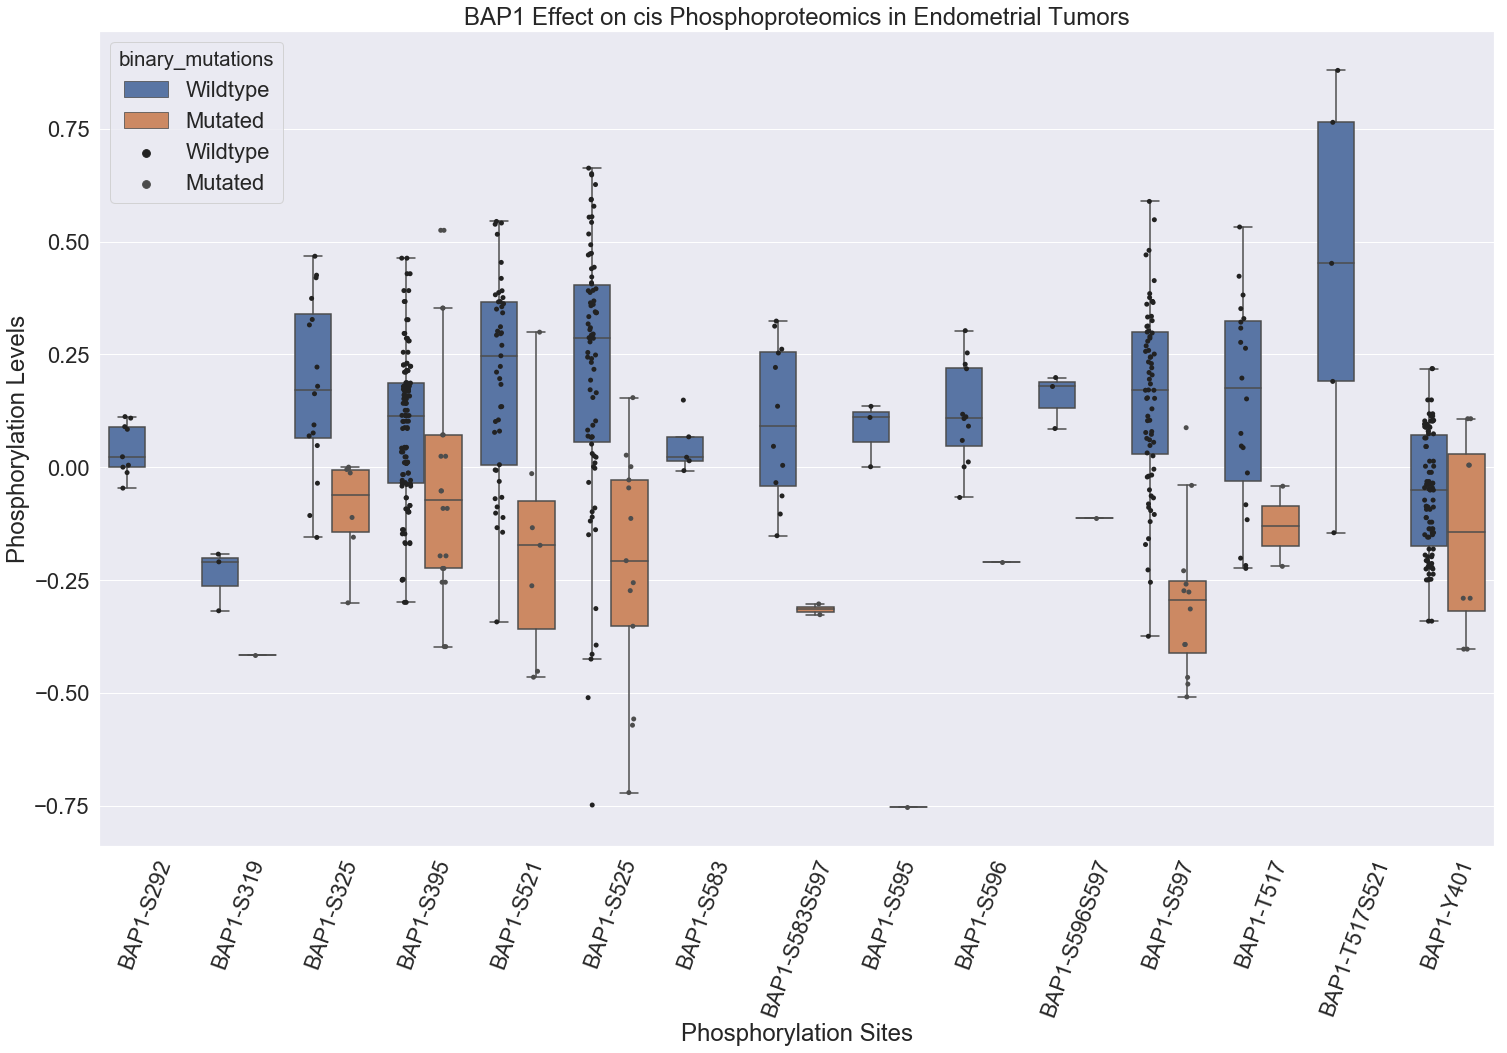

In [18]:
# Step 5 - Create boxplot to compare wildtype and mutated effect on omics data
plt.rcParams['figure.figsize']=(25,15) #size of plot
sns.set(font_scale = 2)
en_cis_boxplot = sns.boxplot(data = sig_phospho_df, x = 'specific_phospho', y = 'phosphoproteomics', hue = 'binary_mutations',
                             hue_order = ["Wildtype","Mutated"], showfliers = False)  
en_cis_boxplot.set_title(gene + " Effect on cis Phosphoproteomics in Endometrial Tumors")
en_cis_boxplot = sns.stripplot(data = sig_phospho_df, x = 'specific_phospho', y = 'phosphoproteomics', hue = 'binary_mutations',
                               hue_order = ["Wildtype","Mutated"], jitter = True, color = ".3", dodge = True)
en_cis_boxplot.set(xlabel = 'Phosphorylation Sites', ylabel = "Phosphorylation Levels")
en_cis_boxplot.set_xticklabels(en_cis_boxplot.get_xticklabels(),rotation = 70)
plt.show()
plt.clf()
plt.close()

The phosphorylation levels decreased in the mutated samples compared to the wildtype.

Repeat the same steps to compare mutation type (missence vs. truncation). Use the function, get_missence_truncation_comparison, to get the mutation type binary column and format the dataframe.

In [19]:
# Steps 1-3
formated_phospho_mut_type = f.get_missence_truncation_comparison(rc_object, 'phosphoproteomics', gene)

In [20]:
# Step 4 - T-test comparing means of missence vs truncation effect on cis omics
print("Doing t-test comparison\n")
sig_pval_mut_type = al.wrap_ttest(formated_phospho_mut_type, 'binary_mutations', omics_col_list)
print(sig_pval_mut_type)

Doing t-test comparison

Incorrectly Formatted Dataframe!
None


C:\Users\brittany henderson\Anaconda3\envs\Research\lib\site-packages\numpy\core\_methods.py:130: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
C:\Users\brittany henderson\Anaconda3\envs\Research\lib\site-packages\cptac\algorithms\__init__.py:82: RuntimeWarning: invalid value encountered in less_equal
  if pval <= bonferroni_cutoff:


No significant comparisons for mutation type.

# Analysis of Results